In [1]:
import torch
import torch.nn as nn
import numpy as np
from PIL import Image
from torchvision import transforms
import cv2
import torch.nn.functional as F
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd

import os

from video_autoencoder import VideoUNetAutoencoder, ShallowVideoUNetAutoencoder, VideoUNetAutoencoderNoSkips, ShallowVideoAutoencoderNoSkips
from customDataset import CustomKineticsDataset_UNet

In [2]:
model = VideoUNetAutoencoderNoSkips(base_channels=32, latent_dim=8)

model.load_state_dict(torch.load("best_autoencoder_1.pth"))

model.eval()

/tmp/ipykernel_43067/2614019232.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_autoencoder_1.pth"))


VideoUNetAutoencoderNoSkips(
  (enc1): Sequential(
    (0): Conv3d(1, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (1): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout3d(p=0.3, inplace=False)
  )
  (enc2): Sequential(
    (0): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
    (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout3d(p=0.3, inplace=False)
  )
  (enc3): Sequential(
    (0): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
    (1): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout3d(p=0.3, inplace=False)
  )
  (enc4): Sequential(
    (0): Conv3d(128, 256, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
    (1): BatchNorm3d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    

In [3]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()
])

In [6]:
def load_clip_as_tensor(clip_path, transform, frames_per_clip=16):
    """Load video clip as tensor with shape (1, C, T, H, W)."""
    cap = cv2.VideoCapture(clip_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    if total_frames == 0:
        cap.release()
        raise ValueError(f"No frames found in {clip_path}")

    # Pick evenly spaced frames
    frame_indices = np.linspace(0, total_frames - 1, frames_per_clip, dtype=int)
    frames = []

    for i in frame_indices:
        cap.set(cv2.CAP_PROP_POS_FRAMES, i)
        ret, frame = cap.read()
        if ret:
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frame_pil = Image.fromarray(frame_rgb)
            frames.append(transform(frame_pil))
    cap.release()

    # Pad if not enough frames
    if len(frames) < frames_per_clip:
        frames += [frames[-1]] * (frames_per_clip - len(frames))

    # Stack → (T, C, H, W)
    frames = torch.stack(frames)

    # Rearrange → (C, T, H, W)
    frames = frames.permute(1, 0, 2, 3)

    # Add batch dimension → (1, C, T, H, W)
    return frames.unsqueeze(0)


def plot_reconstruction_errors(fail_folder, threshold=None,
                               frames_per_clip=32, device=None):

    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model.to(device)
    
    # Preprocessing (same as training)
    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.CenterCrop(224),
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor()
    ])

    clip_folder = os.path.join(fail_folder, "clips")
    total_clips = len([f for f in os.listdir(clip_folder) if f.endswith(".mp4")])

    errors = []

    # Load clips in strict numerical order
    for i in range(1, total_clips + 1):
        clip_name = f"clip_{i}.mp4"
        clip_path = os.path.join(clip_folder, clip_name)

        try:
            clip_tensor = load_clip_as_tensor(clip_path, transform, frames_per_clip).to(device)

            with torch.no_grad():
                recon = model(clip_tensor)

            # Compute reconstruction error (average L1 across all dims)
            loss = torch.nn.L1Loss()
            clip_loss = loss(clip_tensor, recon)
            errors.append(clip_loss.item())
        except Exception as e:
            print(f"⚠️ Error processing {clip_path}: {e}")
            errors.append(np.nan)

    errors_np = np.array(errors, dtype=np.float32)

    # Normalize errors ignoring NaNs
    valid_errors = errors_np[~np.isnan(errors_np)]
    if len(valid_errors) > 0:
        min_err, max_err = valid_errors.min(), valid_errors.max()
        if max_err - min_err > 0:
            errors_normalized = (errors_np - min_err) / (max_err - min_err)
        else:
            errors_normalized = np.zeros_like(errors_np)
    else:
        errors_normalized = errors_np

    plt.figure(figsize=(12, 6))
    x = range(1, len(errors_normalized) + 1)
    plt.plot(x, errors_normalized, marker="o", color="blue", label="Normalized Reconstruction Error")

    # Add threshold line if given
    if threshold is not None:
        plt.axhline(y=threshold, color="red", linestyle="--", label=f"Threshold = {threshold:.2f}")

    # Annotate points
    for i, e in zip(x, errors_normalized):
        if not np.isnan(e):
            plt.text(i, e + 0.01, f"{e:.2f}", ha="center", fontsize=8)

    plt.xticks(ticks=x)
    plt.xlabel("Clips")
    plt.ylabel("Normalized Reconstruction Error")
    plt.title(f"Normalized Reconstruction Errors / Clip - {fail_folder}/clips")
    plt.legend()
    plt.tight_layout()
    plt.show()

    return errors_normalized

def reconstruction_errors_line_plot_3(name, reconstruction_errors, threshold):
    # Ensure the output folder exists
    output_dir = "output/recon/sensor"
    os.makedirs(output_dir, exist_ok=True)

    clip_labels = [f'{i+1}' for i in range(len(reconstruction_errors))]

    plt.figure(figsize=(10, 6))
    plt.plot(clip_labels, reconstruction_errors, color='blue', label='Reconstruction Error')

    plt.xlabel('Clips', fontsize=14)
    plt.ylabel('Reconstruction Error', fontsize=14)
    plt.title(f'Reconstruction Errors / Clip - {name}', fontsize=16)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

    # Add value labels on each point
    for i, error in enumerate(reconstruction_errors):
        plt.text(i, error, f'{error:.2f}', ha='center', va='bottom', fontsize=11)

    plt.axhline(y=threshold, color='red', linestyle='--', label=f'Threshold: {threshold:.3f}')
    plt.legend(fontsize=12)

    plt.tight_layout()

    # Save the plot
    name = name.split('/')[1]
    filename = f"{name}_reconstruction_errors.png"
    filepath = os.path.join(output_dir, filename)
    plt.savefig(filepath, format='png')
    print(f"Plot saved to: {filepath}")

    plt.show()

def plot_reconstruction_errors_3(fail_folder, threshold=None,
                                  frames_per_clip=32, device=None):
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model.to(device)

    # Preprocessing (same as training)
    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.CenterCrop(224),
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor()
    ])

    clip_folder = os.path.join(fail_folder, "clips")
    total_clips = len([f for f in os.listdir(clip_folder) if f.endswith(".mp4")])

    errors = []

    # Load clips in strict numerical order
    for i in range(1, total_clips + 1):
        clip_name = f"clip_{i}.mp4"
        clip_path = os.path.join(clip_folder, clip_name)

        try:
            clip_tensor = load_clip_as_tensor(clip_path, transform, frames_per_clip).to(device)

            with torch.no_grad():
                recon = model(clip_tensor)

            # Compute reconstruction error (average L1 across all dims)
            loss = torch.nn.L1Loss()
            clip_loss = loss(clip_tensor, recon)
            errors.append(clip_loss.item())
        except Exception as e:
            print(f"⚠️ Error processing {clip_path}: {e}")
            errors.append(np.nan)

    errors_np = np.array(errors, dtype=np.float32)

    # --- Plotting ---
    plt.figure(figsize=(12, 6))
    x = range(1, len(errors_np) + 1)
    plt.plot(x, errors_np, marker="o", color="blue", label="Reconstruction Error")

    if threshold is not None:
        plt.axhline(y=threshold, color="red", linestyle="--", label=f"Threshold = {threshold:.3f}")

    for i, e in zip(x, errors_np):
        if not np.isnan(e):
            plt.text(i, e + (0.01 * np.nanmax(errors_np)), f"{e:.2f}", ha="center", fontsize=8)

    plt.xticks(ticks=x)
    plt.xlabel("Clips")
    plt.ylabel("Reconstruction Error (L1)")
    plt.title(f"Reconstruction Errors / Clip - {fail_folder}/clips")
    plt.legend()
    plt.tight_layout()

    # --- Save plot ---
    output_dir = os.path.join("output", "recon", "baseline")
    os.makedirs(output_dir, exist_ok=True)

    # Generate a clean filename from the fail_folder
    fail_name = os.path.basename(os.path.normpath(fail_folder))
    output_path = os.path.join(output_dir, f"{fail_name}_recon_errors.png")
    plt.savefig(output_path)
    print(f"✅ Plot saved to {output_path}")

    plt.show()

    return errors_np

def plot_reconstruction_errors_2(fail_folder, threshold=None,
                               frames_per_clip=32, device=None):
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model.to(device)
    
    # Preprocessing (same as training)
    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.CenterCrop(224),
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor()
    ])

    clip_folder = os.path.join(fail_folder, "clips")
    total_clips = len([f for f in os.listdir(clip_folder) if f.endswith(".mp4")])

    errors = []

    # Load clips in strict numerical order
    for i in range(1, total_clips + 1):
        clip_name = f"clip_{i}.mp4"
        clip_path = os.path.join(clip_folder, clip_name)

        try:
            clip_tensor = load_clip_as_tensor(clip_path, transform, frames_per_clip).to(device)

            with torch.no_grad():
                recon = model(clip_tensor)

            # Compute reconstruction error (average L1 across all dims)
            loss = torch.nn.L1Loss()
            clip_loss = loss(clip_tensor, recon)
            errors.append(clip_loss.item())
        except Exception as e:
            print(f"⚠️ Error processing {clip_path}: {e}")
            errors.append(np.nan)

    errors_np = np.array(errors, dtype=np.float32)

    # --- No normalization ---
    plt.figure(figsize=(12, 6))
    x = range(1, len(errors_np) + 1)
    plt.plot(x, errors_np, marker="o", color="blue", label="Reconstruction Error")

    # Add threshold line if given
    if threshold is not None:
        plt.axhline(y=threshold, color="red", linestyle="--", label=f"Threshold = {threshold:.3f}")

    # Annotate points
    for i, e in zip(x, errors_np):
        if not np.isnan(e):
            plt.text(i, e + (0.01 * np.nanmax(errors_np)), f"{e:.2f}", ha="center", fontsize=8)

    plt.xticks(ticks=x)
    plt.xlabel("Clips")
    plt.ylabel("Reconstruction Error (L1)")
    plt.title(f"Reconstruction Errors / Clip - {fail_folder}/clips")
    plt.legend()
    plt.tight_layout()
    plt.show()

    return errors_np

✅ Plot saved to output/recon/baseline/1_p2_fail - drop cup_recon_errors.png


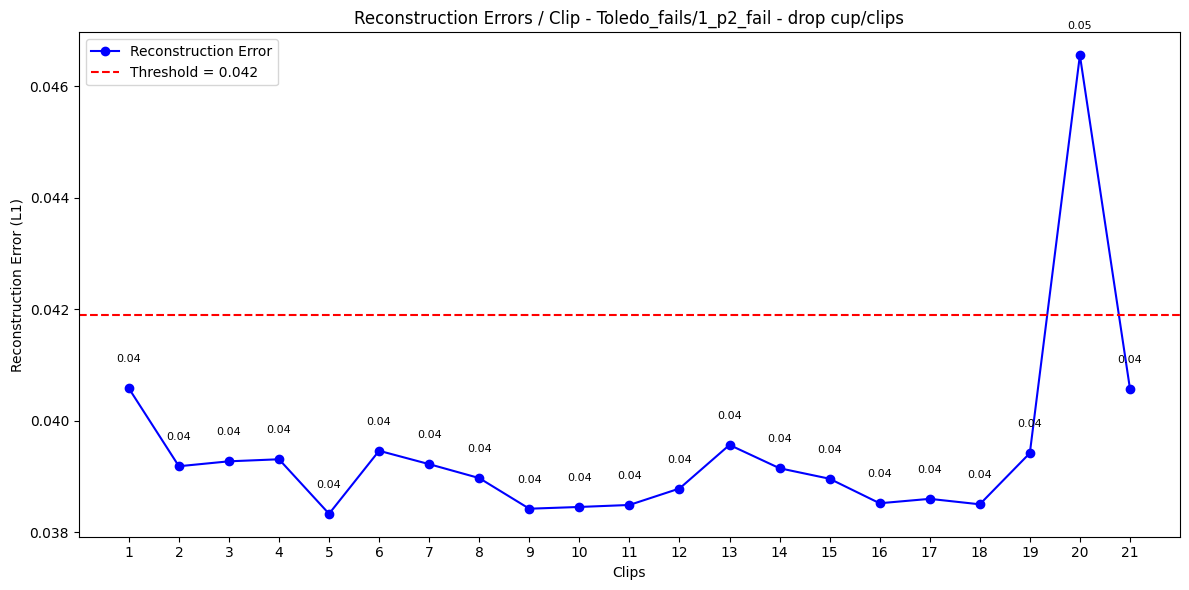

[0.04058518 0.03918783 0.03927605 0.03931274 0.03833476 0.03946516
 0.03922521 0.03897541 0.03842593 0.03845731 0.03849315 0.03878798
 0.03957009 0.03915186 0.03896335 0.03852375 0.03860283 0.03850492
 0.039423   0.04655959 0.0405798 ]


In [7]:
errors = plot_reconstruction_errors_3(
    fail_folder="Toledo_fails/1_p2_fail - drop cup",
    threshold=0.0419
)
print(errors)

✅ Plot saved to output/recon/baseline/Joao_4_fail - Joint Torque_recon_errors.png


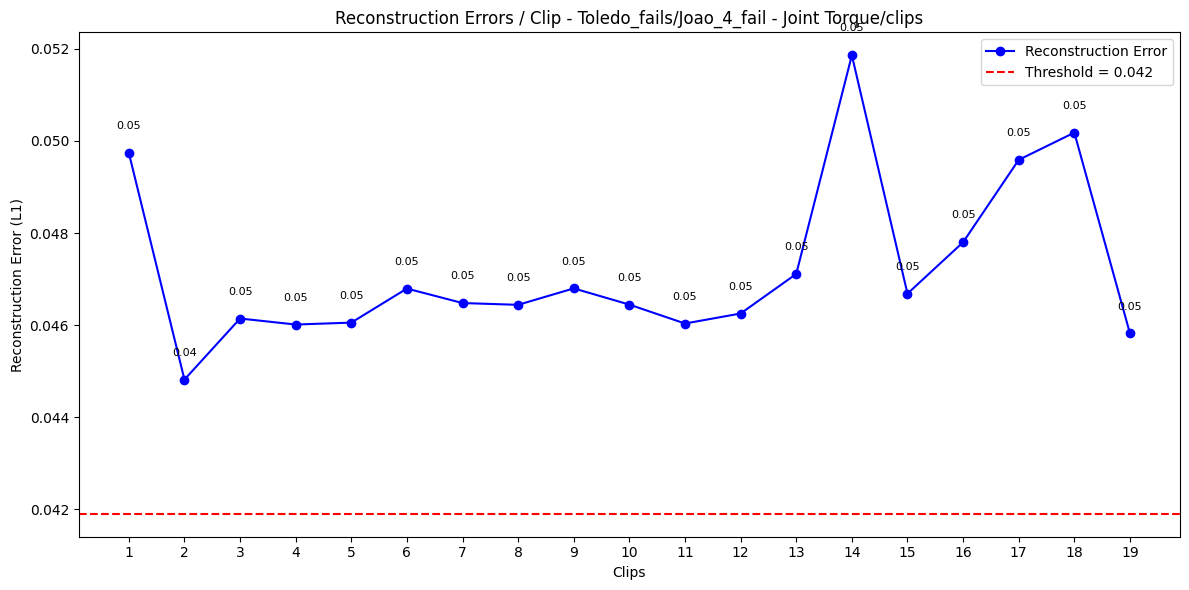

✅ Plot saved to output/recon/baseline/6_Gui_Fail - Robot human handover_recon_errors.png


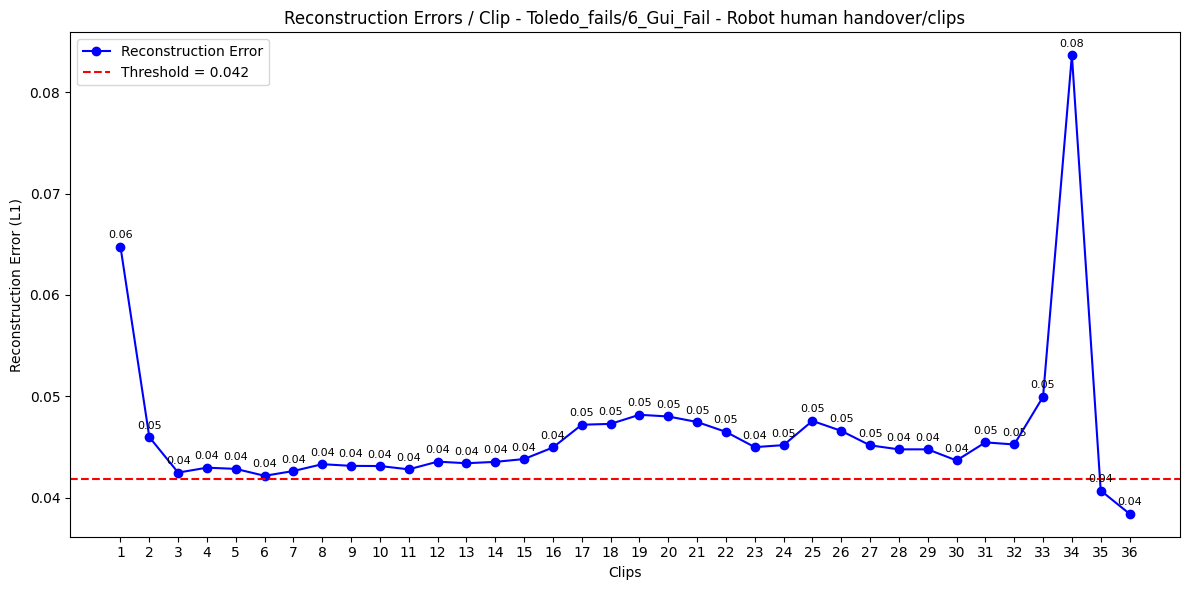

✅ Plot saved to output/recon/baseline/8_p1_fail - drop cup_recon_errors.png


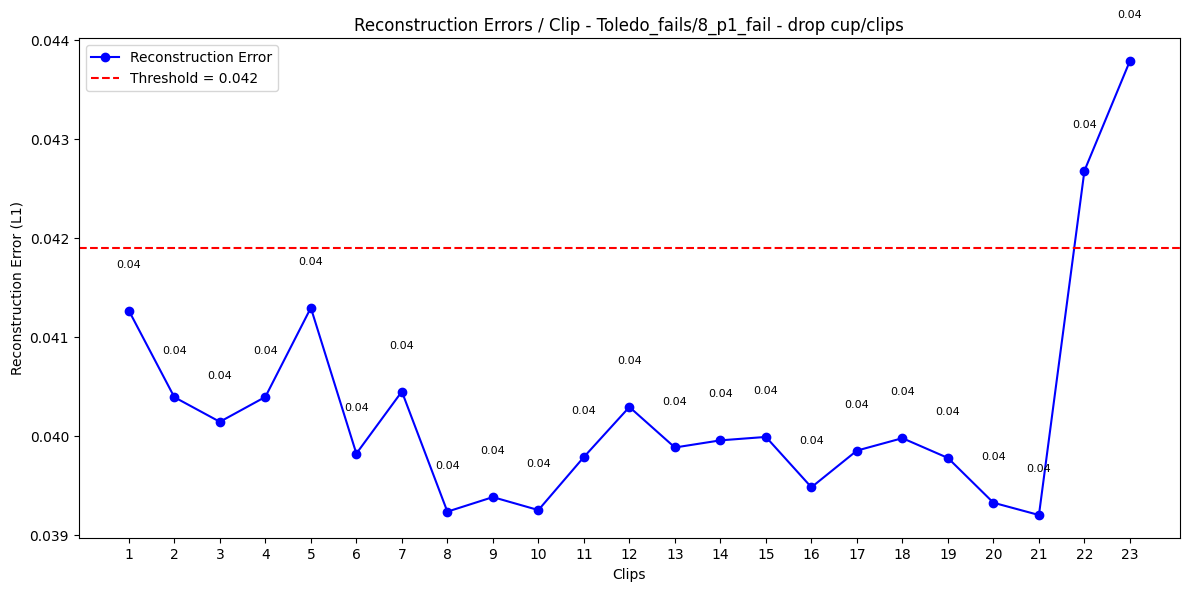

✅ Plot saved to output/recon/baseline/Gui_Fail - Inside the tube_recon_errors.png


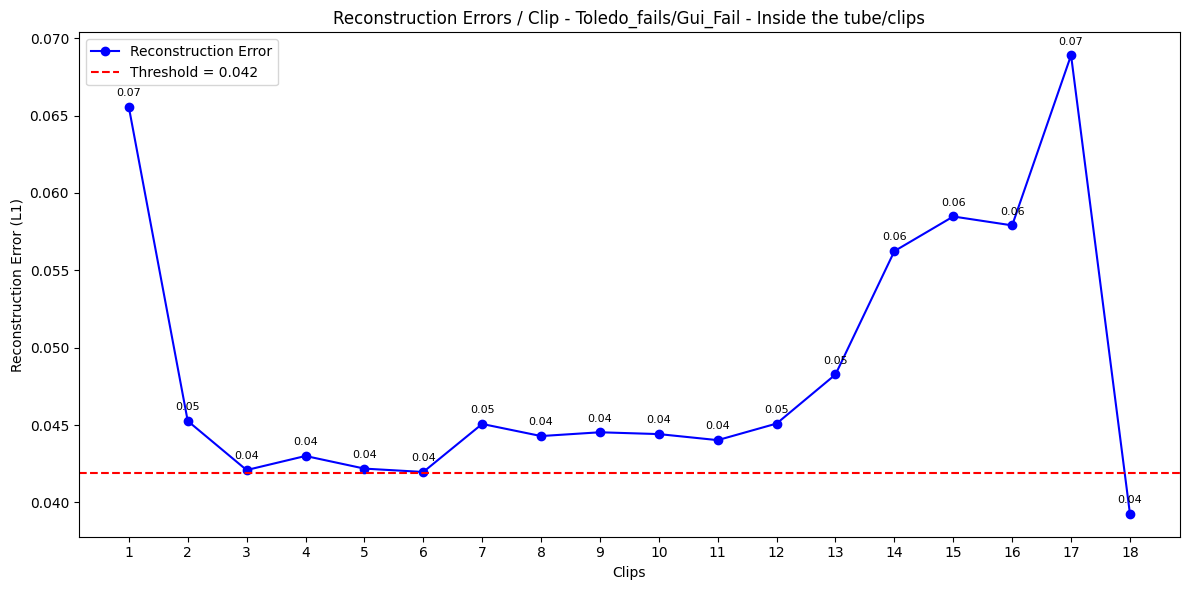

✅ Plot saved to output/recon/baseline/10_Gui_Fail_2 - Fail to grasp cup_recon_errors.png


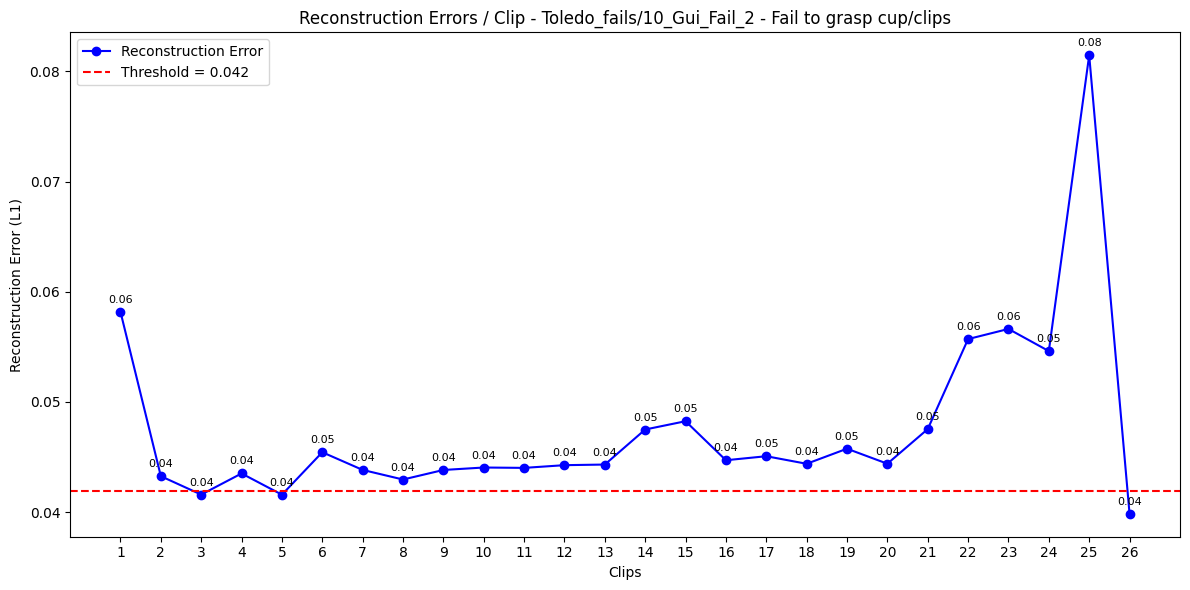

✅ Plot saved to output/recon/baseline/10_Gui_Fail - Extra person_recon_errors.png


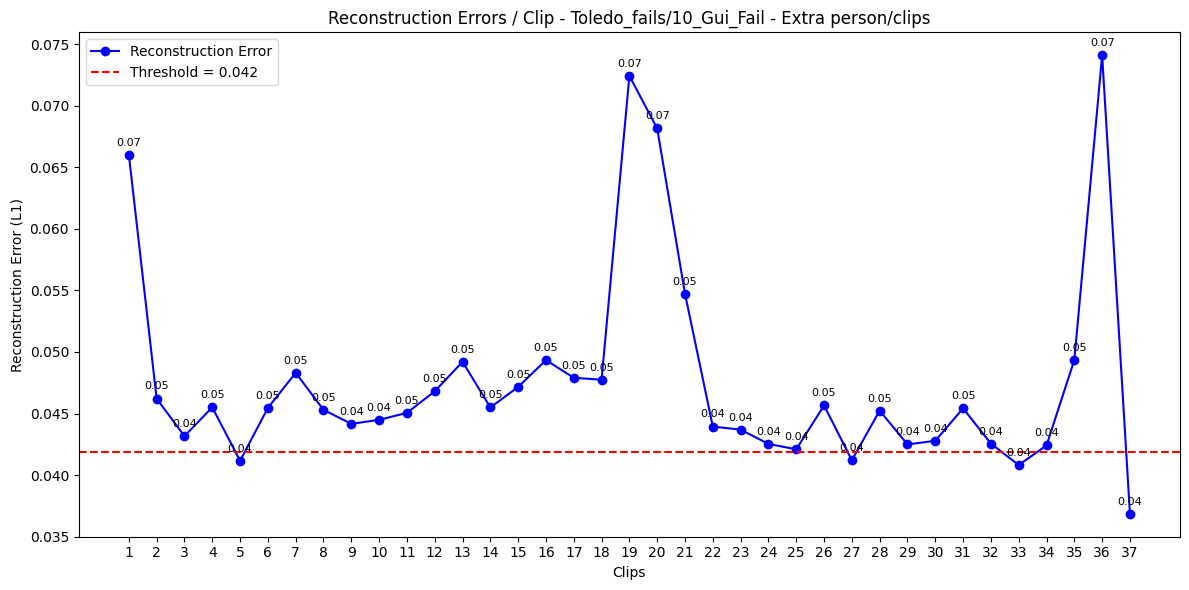

✅ Plot saved to output/recon/baseline/7_Gui_Fail - joint torque_recon_errors.png


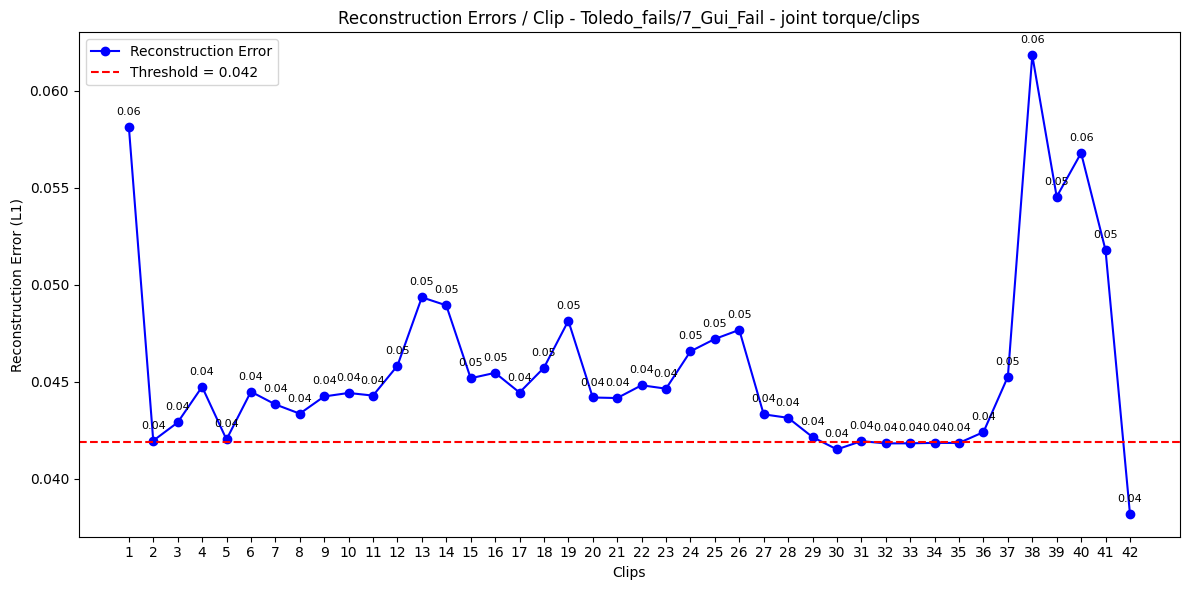

✅ Plot saved to output/recon/baseline/Joao_2_fail - Collision_recon_errors.png


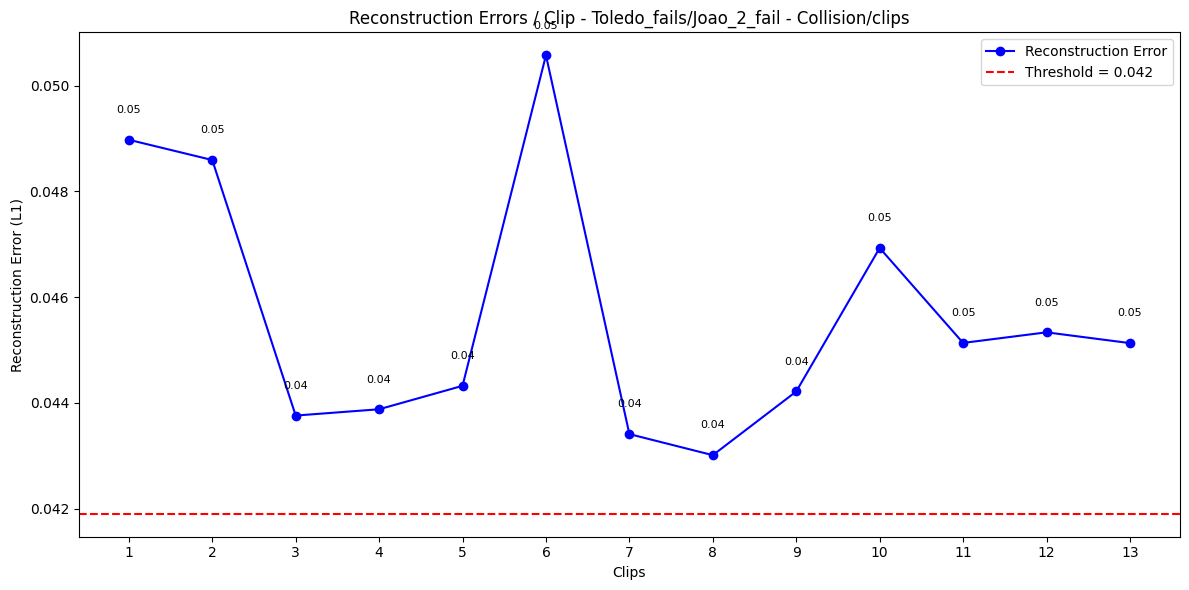

✅ Plot saved to output/recon/baseline/10_Joao_fail_recon_errors.png


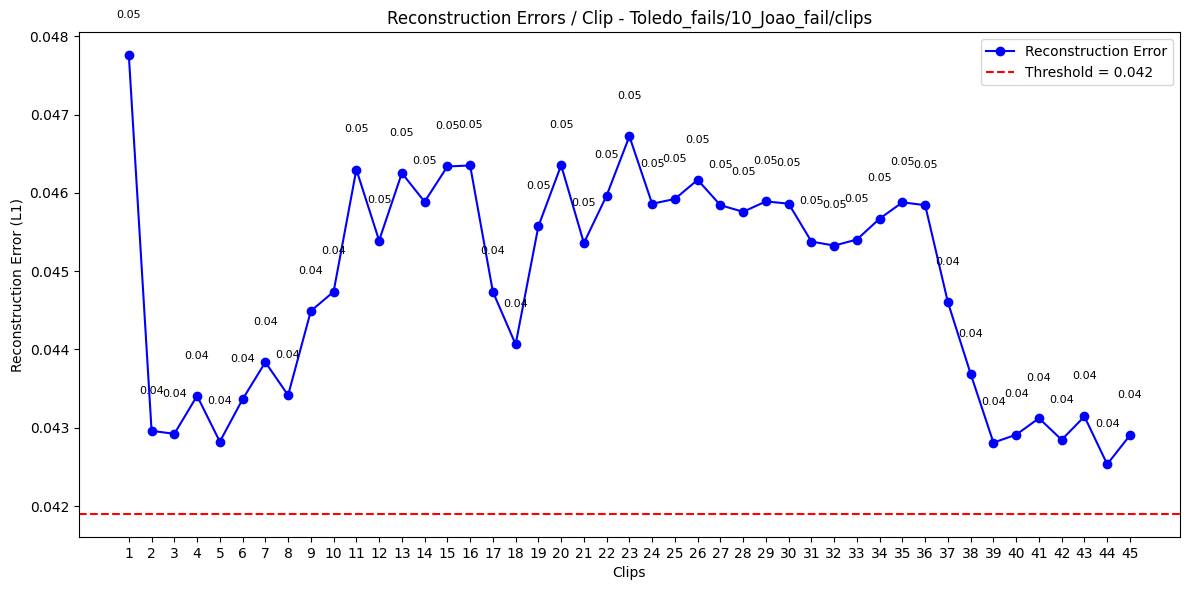

✅ Plot saved to output/recon/baseline/Joao_5_fail - fail to grasp cup_recon_errors.png


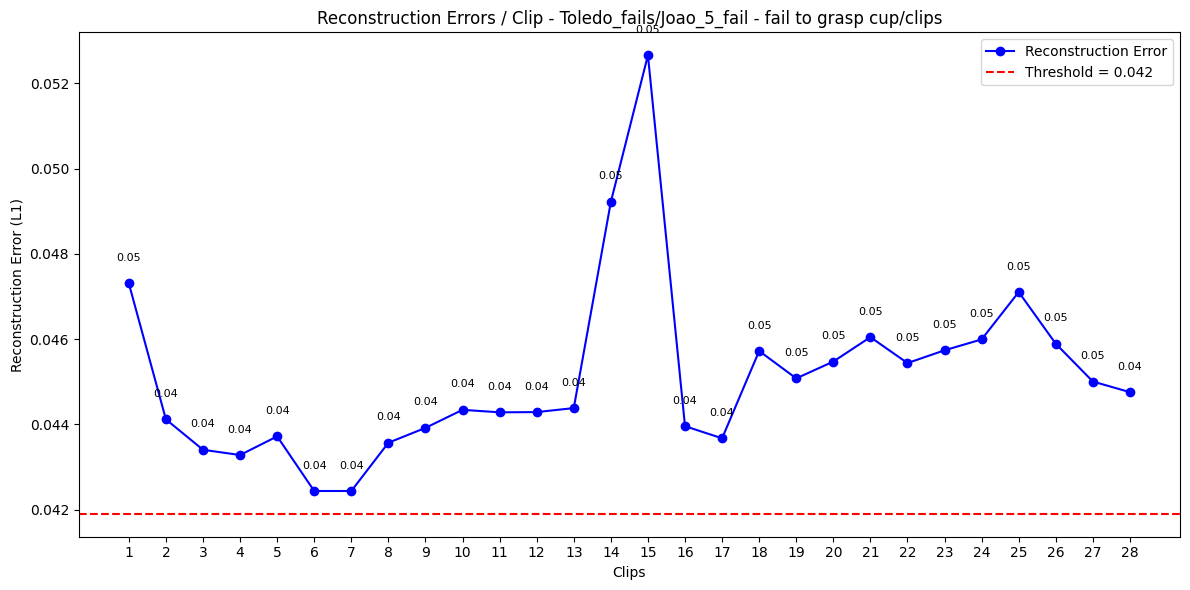

✅ Plot saved to output/recon/baseline/4_Hugo_fail - drop_recon_errors.png


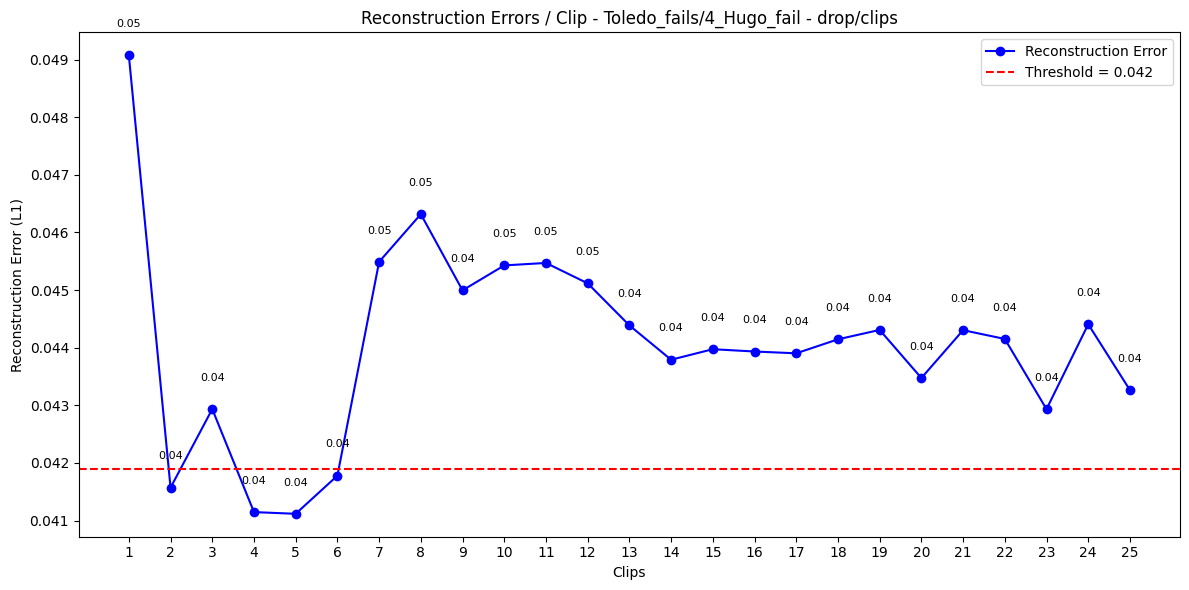

⚠️ Error processing Toledo_fails/fun/clips/clip_1.mp4: No frames found in Toledo_fails/fun/clips/clip_1.mp4
⚠️ Error processing Toledo_fails/fun/clips/clip_2.mp4: No frames found in Toledo_fails/fun/clips/clip_2.mp4
⚠️ Error processing Toledo_fails/fun/clips/clip_3.mp4: No frames found in Toledo_fails/fun/clips/clip_3.mp4
⚠️ Error processing Toledo_fails/fun/clips/clip_4.mp4: No frames found in Toledo_fails/fun/clips/clip_4.mp4
⚠️ Error processing Toledo_fails/fun/clips/clip_5.mp4: No frames found in Toledo_fails/fun/clips/clip_5.mp4
⚠️ Error processing Toledo_fails/fun/clips/clip_6.mp4: No frames found in Toledo_fails/fun/clips/clip_6.mp4
⚠️ Error processing Toledo_fails/fun/clips/clip_7.mp4: No frames found in Toledo_fails/fun/clips/clip_7.mp4
⚠️ Error processing Toledo_fails/fun/clips/clip_8.mp4: No frames found in Toledo_fails/fun/clips/clip_8.mp4
⚠️ Error processing Toledo_fails/fun/clips/clip_9.mp4: No frames found in Toledo_fails/fun/clips/clip_9.mp4
⚠️ Error processing Toledo_f

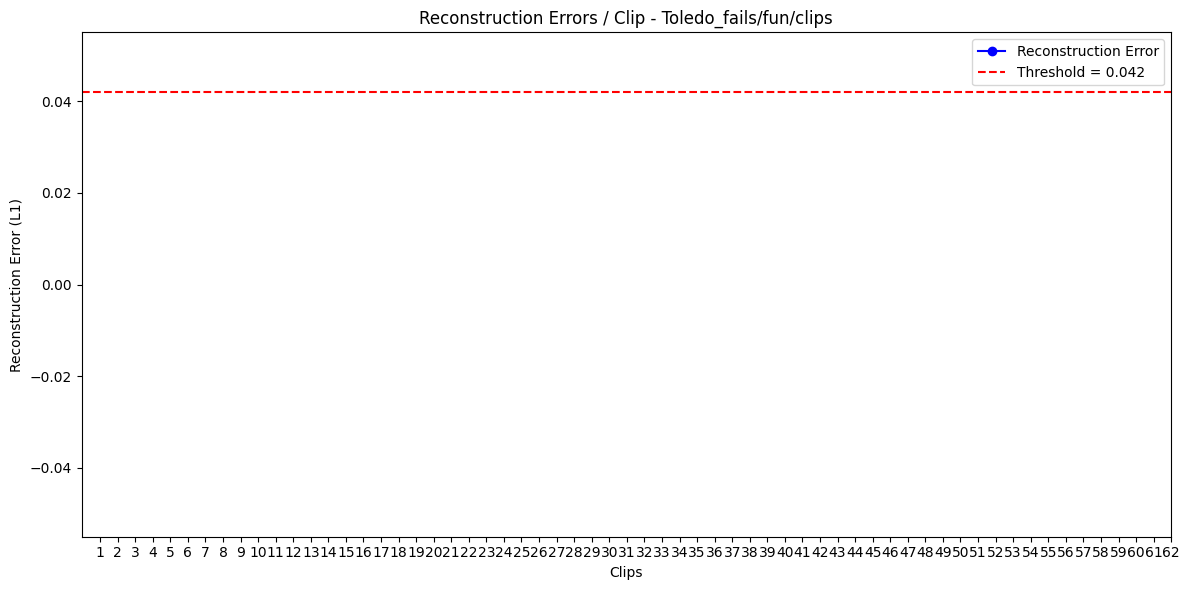

✅ Plot saved to output/recon/baseline/3_p2_fail - robot human handover_recon_errors.png


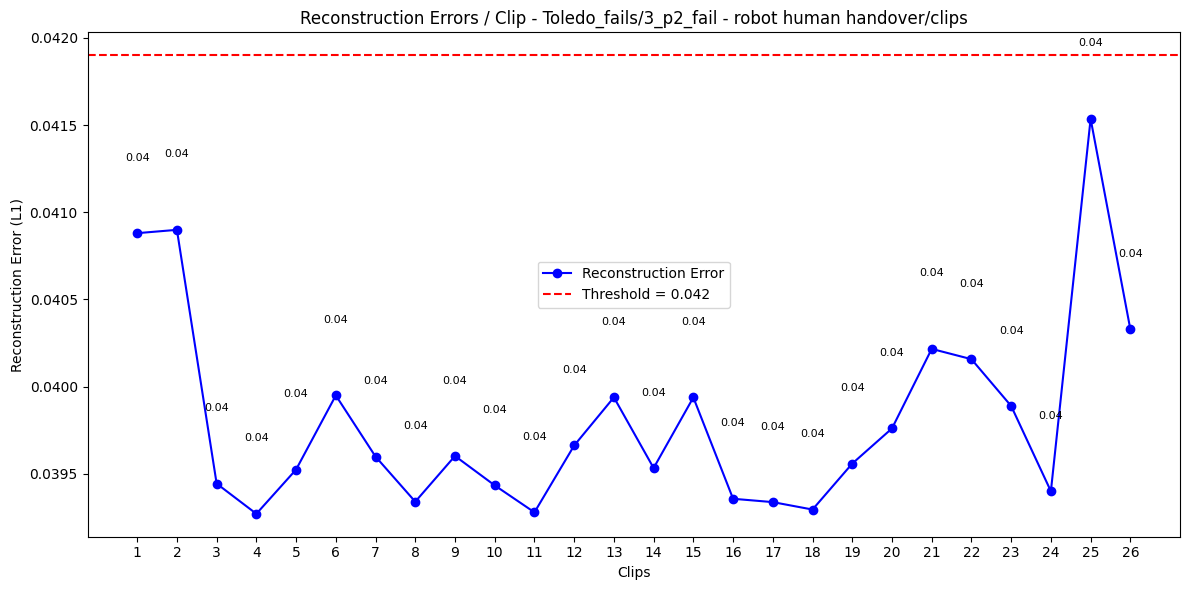

✅ Plot saved to output/recon/baseline/Joao_1_fail - Drop Cup_recon_errors.png


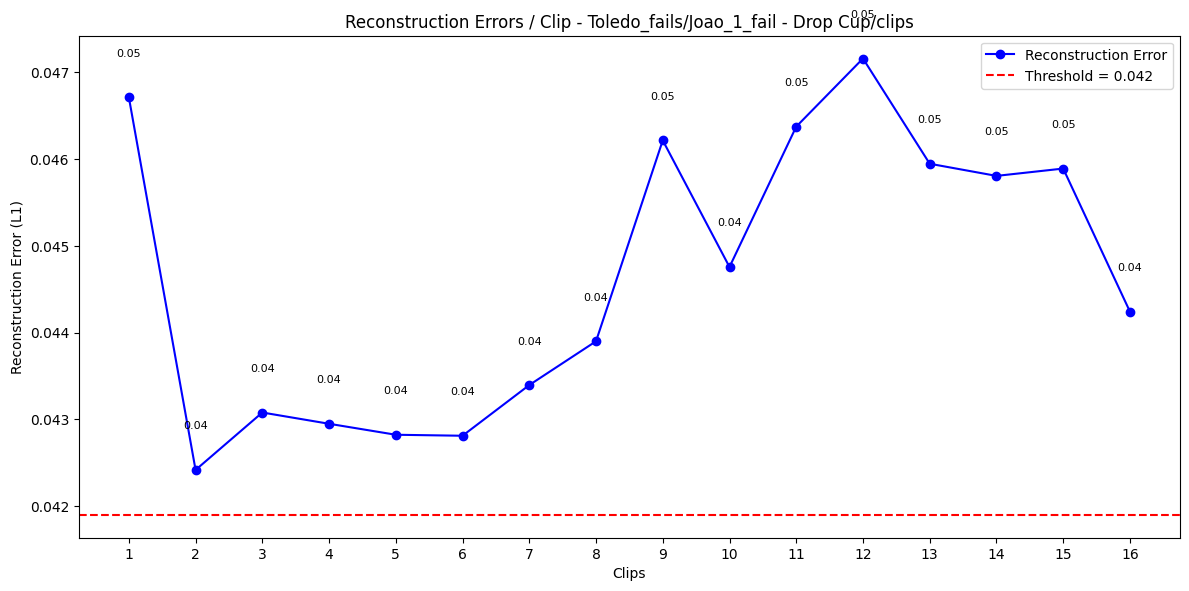

⚠️ Error processing Toledo_fails/Joao_3_fail - Collision/clips/clip_18.mp4: No frames found in Toledo_fails/Joao_3_fail - Collision/clips/clip_18.mp4
✅ Plot saved to output/recon/baseline/Joao_3_fail - Collision_recon_errors.png


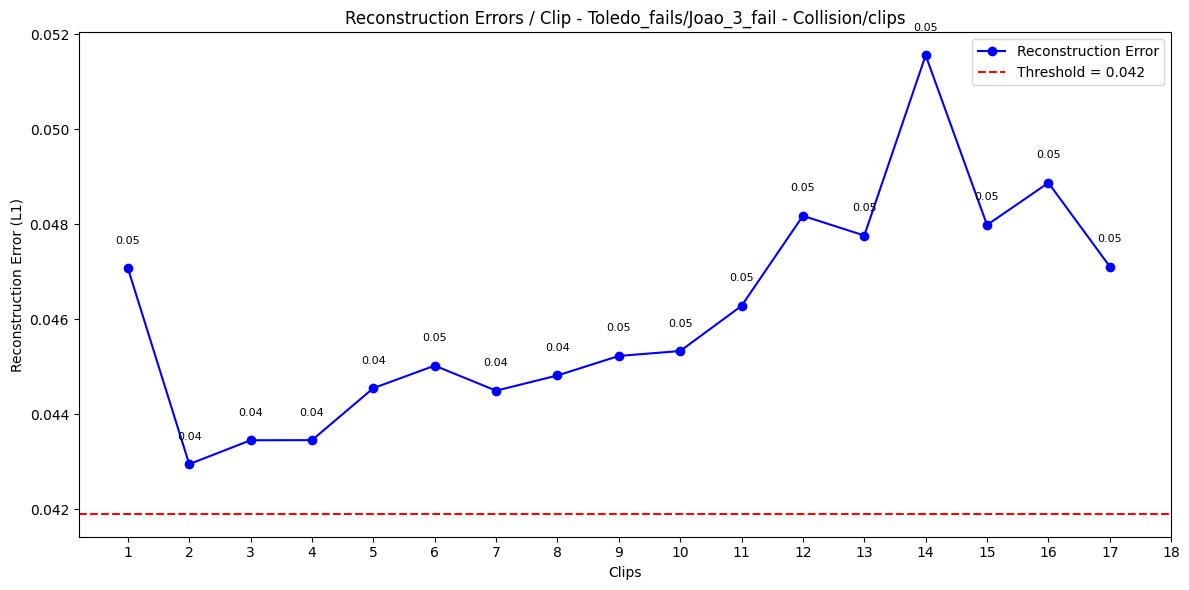

✅ Plot saved to output/recon/baseline/Gui_Fail_2 - Inside the tube_recon_errors.png


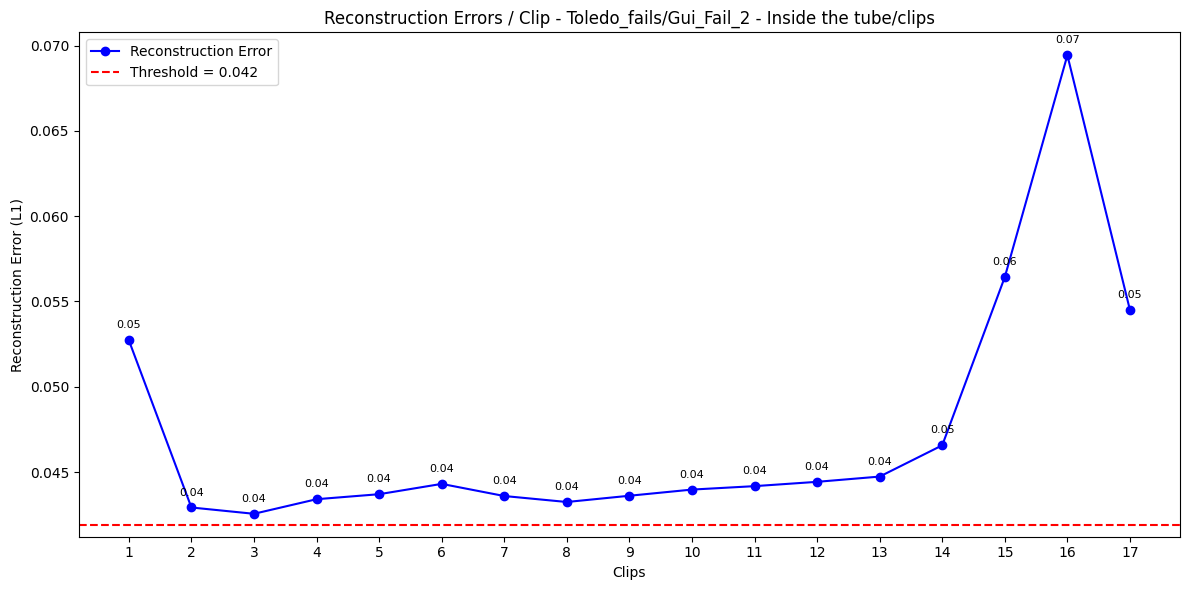

✅ Plot saved to output/recon/baseline/1_p2_fail - drop cup_recon_errors.png


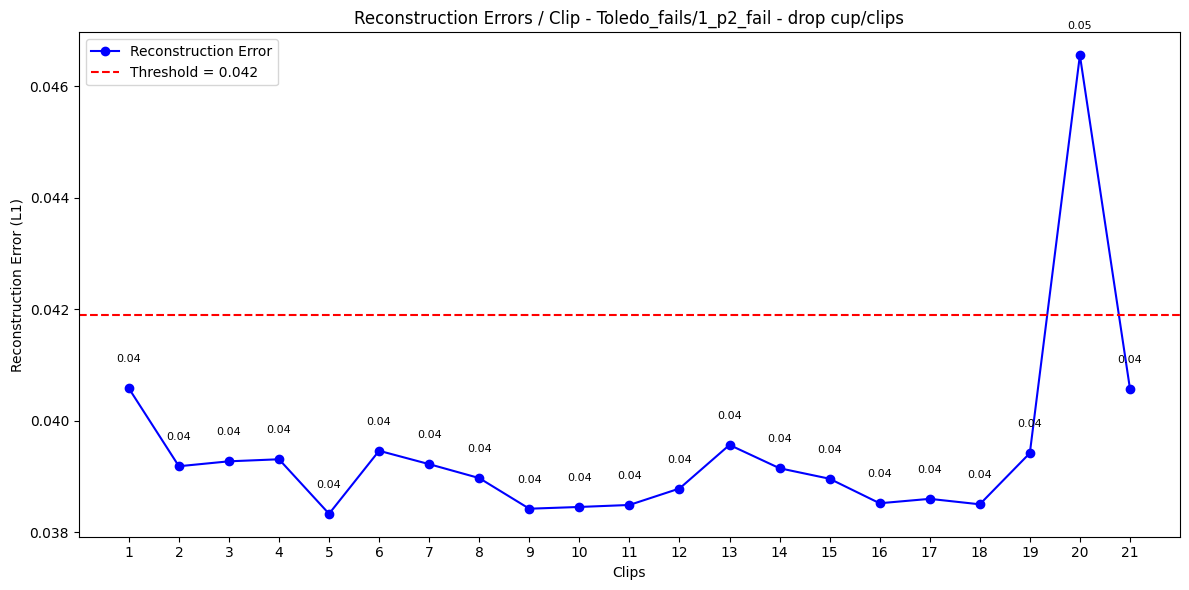

⚠️ Error processing Toledo_fails/Gui_Fail_3 - Person Disappears/clips/clip_35.mp4: No frames found in Toledo_fails/Gui_Fail_3 - Person Disappears/clips/clip_35.mp4
✅ Plot saved to output/recon/baseline/Gui_Fail_3 - Person Disappears_recon_errors.png


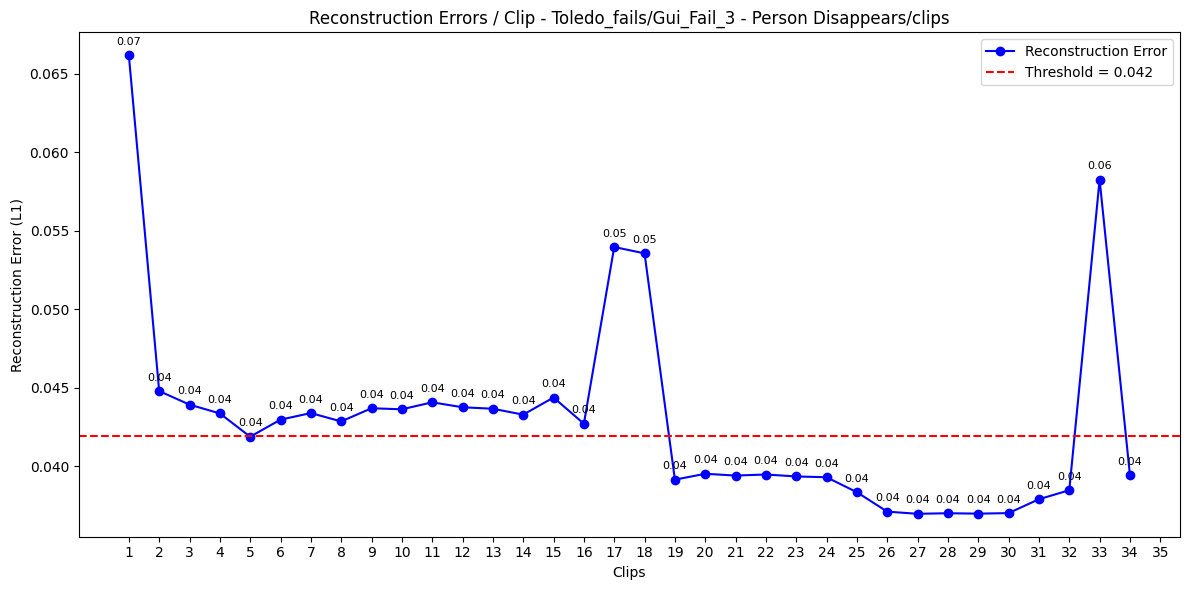

In [8]:
main = 'Toledo_fails'
all_recons_errors = {}
for video in os.listdir(main):
    if video == '9_p1_fail - drop cup':
        continue
    video_path = os.path.join(main, video)
    model.eval()
    reconstruction_errors = plot_reconstruction_errors_3(
                                                    fail_folder=video_path,
                                                    threshold=0.0419
                                                    )
    
    all_recons_errors[video_path] = reconstruction_errors

In [7]:
exclude_keys = ["Toledo_fails/fun", "Toledo_fails/10_Joao_fail"]

for k, v in all_recons_errors.items():
    print(f'{k} : {len(v)}')

all_values = np.concatenate([v for k, v in all_recons_errors.items() if k not in exclude_keys])
print(len(all_values))

Toledo_fails/Joao_4_fail - Joint Torque : 19
Toledo_fails/6_Gui_Fail - Robot human handover : 36
Toledo_fails/8_p1_fail - drop cup : 23
Toledo_fails/Gui_Fail - Inside the tube : 18
Toledo_fails/10_Gui_Fail_2 - Fail to grasp cup : 26
Toledo_fails/10_Gui_Fail - Extra person : 37
Toledo_fails/7_Gui_Fail - joint torque : 42
Toledo_fails/Joao_2_fail - Collision : 13
Toledo_fails/10_Joao_fail : 45
Toledo_fails/Joao_5_fail - fail to grasp cup : 28
Toledo_fails/4_Hugo_fail - drop : 25
Toledo_fails/fun : 62
Toledo_fails/3_p2_fail - robot human handover : 26
Toledo_fails/Joao_1_fail - Drop Cup : 16
Toledo_fails/Joao_3_fail - Collision : 18
Toledo_fails/Gui_Fail_2 - Inside the tube : 17
Toledo_fails/1_p2_fail - drop cup : 21
Toledo_fails/Gui_Fail_3 - Person Disappears : 35
400


In [8]:
anomaly_mask = [0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1, # 19
                0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0, # 36
                0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1, # 23
                0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1, # 18
                0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1, # 26
                0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1, # 37
                0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1, #42
                0,0,0,0,0,0,0,0,0,1,1,1,1, # 13
                0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1, # 28
                0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0, # 25
                0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1, # 26
                0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1, # 16
                0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1, # 18
                0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1, # 17
                0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1, # 21
                0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1] #35 


anomaly_mask = np.array(anomaly_mask, dtype=bool)
print(len(anomaly_mask))
print(len(all_values))

400
400


In [9]:
all_values = np.nan_to_num(all_values, nan=0.0)

normal_values = all_values[~anomaly_mask]
anomalous_values = all_values[anomaly_mask]

mean = all_values.mean()
normal_values_mean = normal_values.mean()
anomalous_values_mean = anomalous_values.mean()

std = all_values.std()
normal_values_std = normal_values.std()
anomalous_values_std = anomalous_values.std()

percentiles = np.percentile(all_values, [25, 50, 75, 90, 95, 99])
normal_values_percentiles = np.percentile(normal_values, [25, 50, 75, 90, 95, 99])
anomalous_values_percentiles = np.percentile(anomalous_values, [25, 50, 75, 90, 95, 99])

print(f'Mean: {mean} ; Std : {std} ; Percentiles : {percentiles}')

print(f'NORMAL : Mean: {normal_values_mean} ; Std : {normal_values_std} ; Percentiles : {normal_values_percentiles}')
print(f'ANOMALOUS : Mean: {anomalous_values_mean} ; Std : {anomalous_values_std} ; Percentiles : {anomalous_values_percentiles}')

Mean: 0.2660868465900421 ; Std : 0.24437545239925385 ; Percentiles : [0.10565776 0.19600379 0.32714131 0.65450277 0.84059346 1.        ]
NORMAL : Mean: 0.22481560707092285 ; Std : 0.20115694403648376 ; Percentiles : [0.10059471 0.17778699 0.27287665 0.45944561 0.70586711 1.        ]
ANOMALOUS : Mean: 0.3735407888889313 ; Std : 0.30638420581817627 ; Percentiles : [0.15024241 0.28066096 0.57392597 0.95509863 1.         1.        ]


In [10]:
thresholds = np.linspace(all_values.min(), all_values.max(), 100)
best_thr, best_f1 = None, -1

for thr in thresholds:
    preds = all_values > thr
    tp = ((preds == 1) & (anomaly_mask == 1)).sum()
    fp = ((preds == 1) & (anomaly_mask == 0)).sum()
    fn = ((preds == 0) & (anomaly_mask == 1)).sum()
    precision = tp / (tp + fp + 1e-9)
    recall = tp / (tp + fn + 1e-9)
    f1 = 2 * precision * recall / (precision + recall + 1e-9)
    if f1 > best_f1:
        best_f1 = f1
        best_thr = thr
print("Best threshold:", best_thr, "with F1 =", best_f1)

Best threshold: 0.27272727272727276 with F1 = 0.48559670731866755


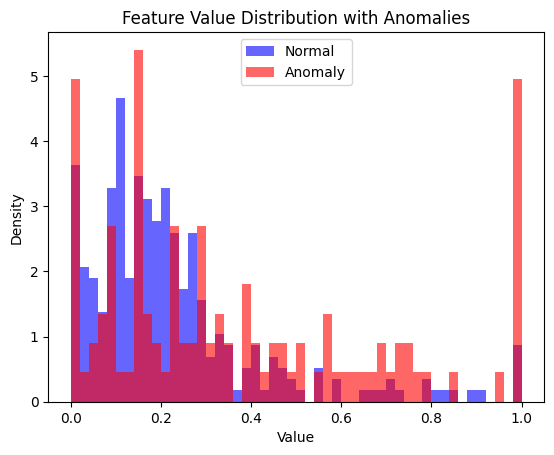

In [11]:
plt.hist(normal_values, bins=50, alpha=0.6, label="Normal", density=True, color="blue")
plt.hist(anomalous_values, bins=50, alpha=0.6, label="Anomaly", density=True, color="red")

plt.title("Feature Value Distribution with Anomalies")
plt.xlabel("Value")
plt.ylabel("Density")
plt.legend()
plt.show()

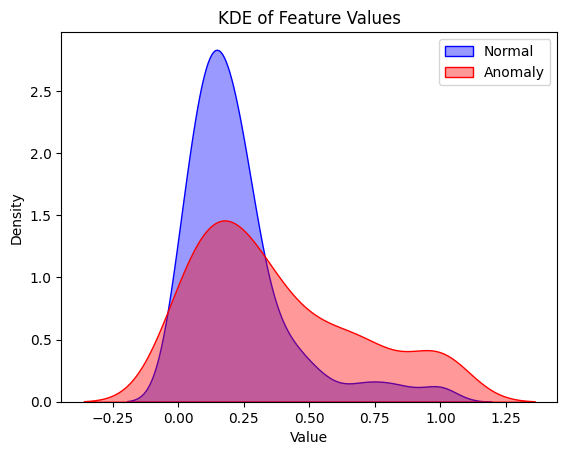

In [12]:
import seaborn as sns

sns.kdeplot(normal_values, label="Normal", color="blue", fill=True, alpha=0.4)
sns.kdeplot(anomalous_values, label="Anomaly", color="red", fill=True, alpha=0.4)

plt.title("KDE of Feature Values")
plt.xlabel("Value")
plt.ylabel("Density")
plt.legend()
plt.show()

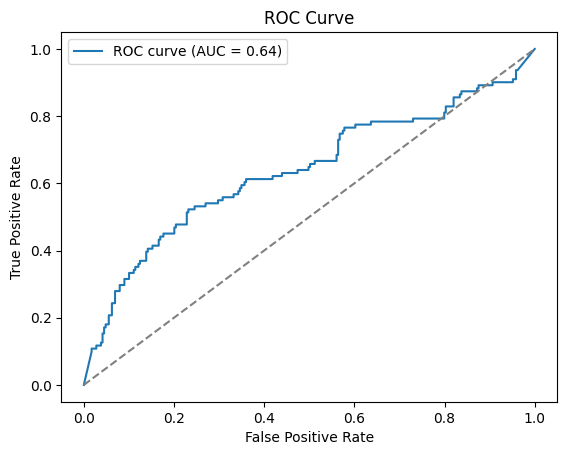

In [13]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(anomaly_mask, all_values)
roc_auc = auc(fpr, tpr)

np.savez("roc_baseline.npz", fpr=fpr, tpr=tpr, roc_auc=roc_auc)

plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")  # random line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()